In [ ]:
import cv2
import pytesseract

# Optional: Set path to tesseract executable (for Windows)
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"


def preprocess_image(img_path):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Binarization - makes text more visible
    thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return thresh

def extract_handwritten_text(img_path):
    preprocessed_img = preprocess_image(img_path)
    text = pytesseract.image_to_string(preprocessed_img, config='--psm 6')
    return text

# Example usage
# img_file = 'data/handwritten_sample.jpeg'
# img_file = 'data/handwritten_sample1.jpg'
img_file = 'data/text_sample.png'
extracted_text = extract_handwritten_text(img_file)
print("Extracted Text:\n", extracted_text)


In [ ]:
!pip install transformers einops timm pillow

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, AutoModel
from PIL import Image
import torch
import cv2


# Initialize the model
model = AutoModel.from_pretrained('jinaai/jina-clip-v2', trust_remote_code=True)

# Choose a matryoshka dimension, set to None to get the full 1024-dim vectors
truncate_dim = 512

all_images = ['https://i.ibb.co/nQNGqL0/beach1.jpg', 'https://i.ibb.co/r5w8hG8/beach2.jpg']
image_embeddings = model.encode_image(
    all_images[:2], truncate_dim=truncate_dim
)

# Load processor and model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

def extract_handwritten_text_trocr(image_path):
    image = Image.open(image_path).convert("RGB")

    # Preprocess and generate
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)

    # Decode output
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return text

# Example usage
img_path = "data/handwritten_sample.jpeg"
img = cv2.imread(img_path)
inverted_image = cv2.bitwise_not(img) # use loaded memeory, not path
cv2.imwrite("temp/handwritten_sample_inverted.jpeg", inverted_image)


inverted_image_path = "data/inverted_handwritten_sample.jpeg"
text = extract_handwritten_text_trocr(img_path)
print("Extracted Text:\n", text)


In [ ]:
import cv2
import numpy as np
from PIL import Image
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Initialize TrOCR components
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
ocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

def upscale_image(img, scale=2):
    return cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

def invert_image(img):
    return cv2.bitwise_not(img)

def sharpen_image(img):
    # Simple sharpening kernel
    kernel = np.array([[0, -1, 0],
                    [-1, 5,-1],
                    [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def clean_image_pipeline(img_path, output_path="temp/cleaned_image.jpeg"):
    # Load image
    img = cv2.imread(img_path)

    # Apply cleaning steps
    img = upscale_image(img)
    img = invert_image(img)
    img = sharpen_image(img)

    # Save cleaned image
    cv2.imwrite(output_path, img)
    return output_path, img

def extract_handwritten_text_trocr_from_cv2img(img):
    pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    pixel_values = processor(images=pil_img, return_tensors="pt").pixel_values
    generated_ids = ocr_model.generate(pixel_values)
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return text

# ---- Example usage ---- #
if __name__ == "__main__":
    cleaned_path, cleaned_img = clean_image_pipeline("data/handwritten_sample.jpeg")
    text = extract_handwritten_text_trocr_from_cv2img(cleaned_img)
    print("Extracted Text:\n", text)


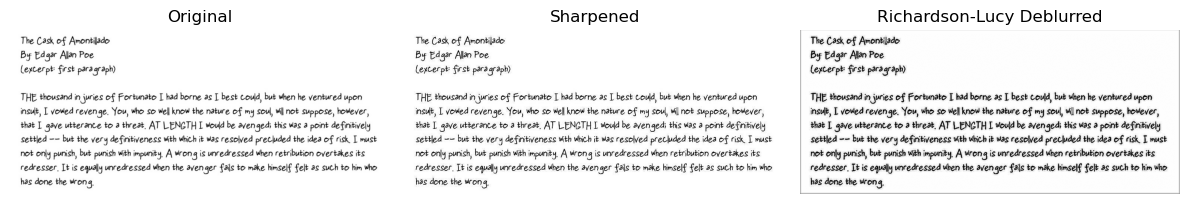

In [17]:
import cv2
import numpy as np
from skimage.restoration import richardson_lucy
from matplotlib import pyplot as plt
import os

# Create output folder
os.makedirs("temp", exist_ok=True)

# Load and convert image to grayscale
img = cv2.imread("data/handwritten_sample.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply sharpening
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
sharpened = cv2.filter2D(gray, -1, sharpen_kernel)

# PSF for deblurring
psf = np.ones((3, 3)) / 9
rl_deblurred = richardson_lucy(sharpened.astype(np.float64) / 255.0, psf, 5)
rl_uint8 = np.clip(rl_deblurred * 255, 0, 255).astype(np.uint8)

# Save outputs
cv2.imwrite("temp/sharpened.jpeg", sharpened)
cv2.imwrite("temp/deblurred.jpeg", rl_uint8)

# Show side-by-side
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1), plt.imshow(gray, cmap='gray'), plt.title("Original"), plt.axis("off")
plt.subplot(1, 3, 2), plt.imshow(sharpened, cmap='gray'), plt.title("Sharpened"), plt.axis("off")
plt.subplot(1, 3, 3), plt.imshow(rl_uint8, cmap='gray'), plt.title("Richardson-Lucy Deblurred"), plt.axis("off")
plt.tight_layout()
plt.show()
